In [1]:
import jax
import numpy as np
from tqdm import tqdm
import jax.numpy as jnp
from flax.core.frozen_dict import FrozenDict

from optimizers import PAGE, SGD, SVRG
from test_opts import MLP

import matplotlib.pyplot as plt

In [2]:
KEY = jax.random.PRNGKey(32)
XDIM = 128
BS = 256
BS_HAT = 16

In [3]:
true_A = jax.random.uniform(KEY, (XDIM, 1))

In [4]:
def generate_batch(batch_size=BS, key: jax.random.PRNGKey=KEY) -> tuple[jnp.ndarray, jnp.ndarray]:
    x = jax.random.uniform(key, (batch_size, XDIM), minval=0, maxval=3)
    y = jnp.dot(x, true_A) + jax.random.normal(key, (batch_size, 1))*0.01
    return x, y

## PAGE

In [5]:
model = MLP()
init_batch = generate_batch(BS)
variables = model.init(KEY, init_batch[0])

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = PAGE(
    loss_fn=loss_fn,
    eval_loss_fn=loss_fn,
    p=BS_HAT/(BS+BS_HAT),
    lr=1e-5,
    bs=BS,
    bs_hat=BS_HAT,
    need_jit=True
)
state = opt.init(variables, init_batch)

In [6]:
# %%time
x_page = []
losses_tmp = []
losses_page = []

with tqdm(range(20_000), desc="Training") as pbar:
    for step in pbar:
        KEY, train_key = jax.random.split(KEY)
        batch = generate_batch(BS, train_key)
        loss, state = opt.update(state, batch)
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_page.append(opt.computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_page.append(mean_loss)
            losses_tmp = []
            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

Training: 100%|██████████| 20000/20000 [00:44<00:00, 449.57it/s, Loss=0.12999999523162842]


## SGB mini-batch

In [8]:
model = MLP()
x0, _ = generate_batch(BS)
variables = model.init(KEY, x0)

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = SGD(
    lr=1e-5,
    loss_fn=loss_fn
)
state =opt.init(variables)

In [9]:
# %%time
x_sgd = []
losses_tmp = []
losses_sgd = []

with tqdm(range(20_000), desc="SGD Training") as pbar:
    for step in pbar:
        train_key, KEY = jax.random.split(KEY)
        batch = generate_batch(BS, train_key)
        loss, state = opt.update(state, batch)
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_sgd.append(opt.computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_sgd.append(mean_loss)
            losses_tmp = []
            
            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

SGD Training: 100%|██████████| 20000/20000 [01:14<00:00, 270.19it/s, Loss=0.13279999792575836]


## SVRG

In [22]:
model = MLP()
init_batch = generate_batch(BS)
variables = model.init(KEY, init_batch[0])

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = SVRG(
    loss_fn=loss_fn,
    lr=1e-5,
    inner_iters=1000,
    need_jit=True
)
state = opt.init(variables, KEY)

In [23]:
computed_grad_count = 0
losses_svrg = []
x_svrg = []
losses_tmp = []

with tqdm(range(20_000), desc="Training SVRG") as pbar:
    for step in pbar:
        if step == 0 or state.inner_step >= opt.inner_iters:
            KEY, batch_key = jax.random.split(KEY)
            batch = generate_batch(BS, batch_key)
            X, Y = generate_batch(BS, KEY)
            state = opt.set_snapshot(state, (X, Y))
            computed_grad_count += BS
        
        loss, state = opt.update(state, batch)
        computed_grad_count += 2
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_svrg.append(computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_svrg.append(mean_loss)
            losses_tmp = []

            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

Training SVRG: 100%|██████████| 20000/20000 [00:35<00:00, 567.91it/s, Loss=0.13009999692440033]


## Результаты экспериментов

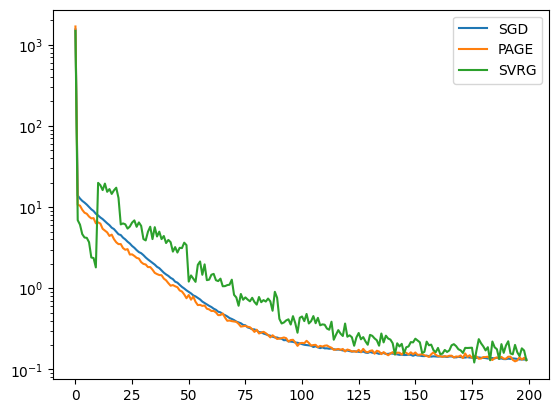

In [24]:
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_page, label='PAGE')
plt.plot(losses_svrg, label='SVRG')
plt.yscale('log')
plt.legend()
plt.show()

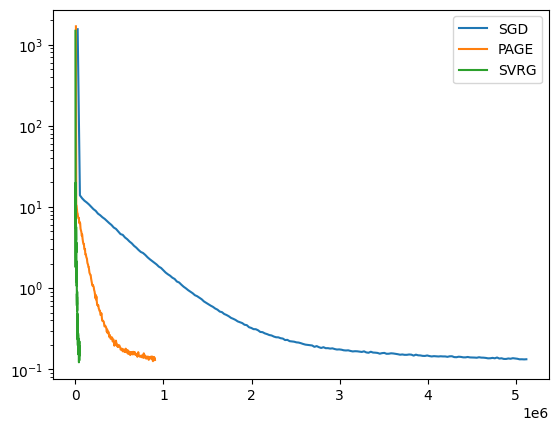

In [25]:
plt.plot(x_sgd, losses_sgd, label='SGD')
plt.plot(x_page, losses_page, label='PAGE')
plt.plot(x_svrg, losses_svrg, label='SVRG')
plt.yscale('log')
plt.legend()
None

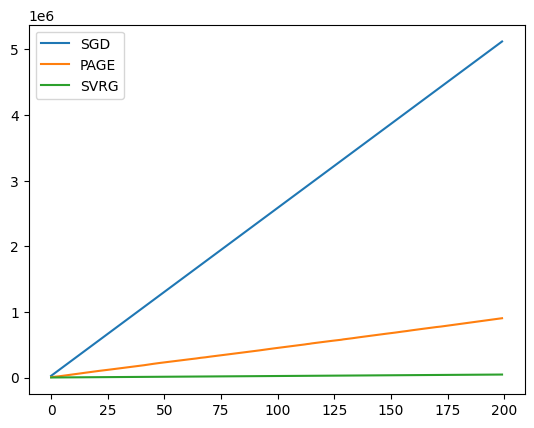

In [26]:
plt.plot(x_sgd, label='SGD')
plt.plot(x_page, label='PAGE')
plt.plot(x_svrg, label='SVRG')
# plt.yscale('log')
plt.legend()
None